In [1]:
import numpy as np
from scipy import stats
import math
import numpy.linalg as linalg
import pandas as pd
from matplotlib import pyplot as plt
import sklearn as skl
from sklearn.preprocessing import PolynomialFeatures
import heapq


In [2]:
def tricubic(x):
    y = np.zeros_like(x)
    idx = (x >= 0) & (x <= 1)
    y[idx] = np.power(1.0 - np.power(np.abs(x[idx]), 3), 3)
    return y

In [3]:
def normalize(array, est):
    stds = array.std(axis=0)
    
    return (array- array.mean(axis=0))/stds, (est - array.mean(axis=0))/stds

In [4]:
def get_max_dist(distances, q):
    mins = []
    for i in range(0, len(distances)):
        if len(mins) >= q:
            if mins[0] < -1*distances[i]:
                heapq.heapreplace(mins, -1*distances[i])
        else:
            heapq.heappush(mins, -1*distances[i])
    
    
    
    return mins[0]*-1

In [5]:
def get_indexes(distances, q):
    mins = []
    for i in range(0, len(distances)):
        if len(mins) >= q:
            if mins[0][0] < -1*distances[i]:
                heapq.heapreplace(mins, (-1*distances[i], i))
        else:
            heapq.heappush(mins, (-1*distances[i], i))
    
    indexes = []
    max_dist = 0.0
    for (dist, index) in mins:
        indexes.append(index)
        
        if -1*dist > max_dist:
            max_dist = -1*dist
            
    return indexes, max_dist

In [6]:
def get_weights(distances, max_dist):
    weights = tricubic(distances/max_dist)
    return np.diag(weights)

In [7]:
def loess(data, Y, to_estimate, f=0.1, fit=1, dist=2, normal=True):
    q = int(math.ceil(f*len(Y)))
    if normal:
        data, to_estimate = normalize(data, to_estimate)
        
    
    poly = PolynomialFeatures(fit)
    cant = len(to_estimate)
    
    y_ests = np.zeros(cant,dtype="float64")
    
    #L es la transformacion lineal de la seccion 4.1
    L = np.zeros((cant, len(Y)))
    
    for i in range(cant):
        distances = linalg.norm(data - to_estimate[i], ord=dist, axis=1)
        #indexes, max_dist = get_indexes(distances, q)   
        max_dist = get_max_dist(distances, q)

        A = poly.fit_transform(data)
        x = poly.transform(to_estimate[i].reshape(1,-1))

        W = get_weights(distances, max_dist)

        b = Y
        
        atw = A.T@W

        coeffsSinB = linalg.pinv(atw@A)@atw
        coeffs = coeffsSinB@b
        
        l = x@coeffsSinB

        y_est = np.dot(coeffs, x[0])
        y_ests[i] = y_est
        L[i] = l
    
    return y_ests, L
    

In [8]:
data = pd.read_csv('../data/dataset.csv',usecols=['ozone', 'radiation', 'temperature', 'wind'])

In [9]:
x=data[['radiation', 'temperature', 'wind']].to_numpy()
y = data['ozone'].to_numpy()
estimates, L = loess(x, y, x, f=0.4, fit=1, dist=2, normal=False)
residuals = y - estimates

Text(0, 0.5, 'Absolute Residuals')

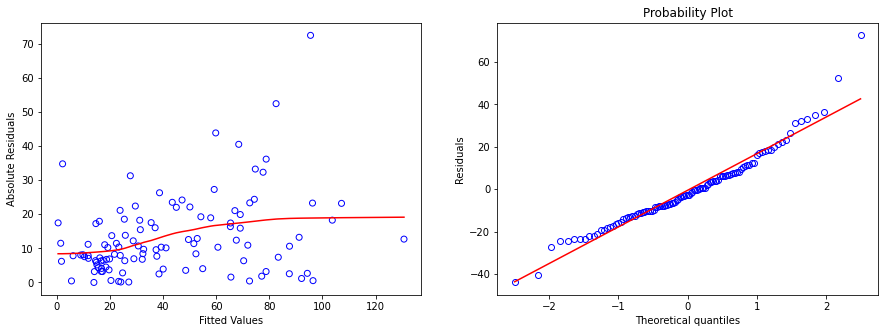

In [10]:

fig, axs = plt.subplots(1,2,figsize=(15,5))

res = stats.probplot(residuals, plot=plt, fit=True)

axs[1].get_lines()[0].set_marker('o')
axs[1].get_lines()[0].set_markeredgecolor('b')
axs[1].get_lines()[0].set_markerfacecolor('none')
axs[1].set_ylabel('Residuals')

abs_res= np.abs(residuals)
abs_res_soft, L = loess(estimates.reshape((len(estimates),1)), abs_res,
                              estimates.reshape((len(estimates),1)), f=0.67, fit=1, dist=2, normal=False)

order_estimates = np.argsort(estimates)

axs[0].scatter(estimates, abs_res, edgecolor='b', facecolor='none')
axs[0].plot(estimates[order_estimates], abs_res_soft[order_estimates], color='r')
axs[0].set_xlabel('Fitted Values')
axs[0].set_ylabel('Absolute Residuals')

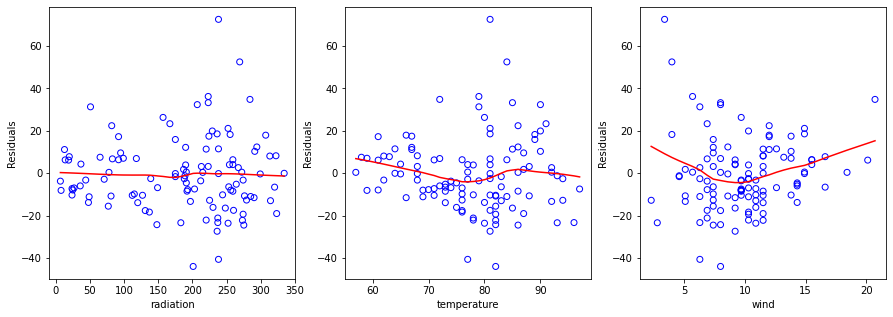

In [11]:
cols = ['radiation','temperature','wind']

fig, axs = plt.subplots(1,3, figsize=(15,5))
for i in range(3):
    x = data[[cols[i]]].to_numpy()
    
    res_est, L = loess(x, residuals, x, f=0.67, fit=1, dist=2, normal=False)
    
    order = np.argsort(x.T[0])

    axs[i].scatter(x, residuals, edgecolor='b', facecolor='none')
    axs[i].plot(x[order], res_est[order], color='r')
    axs[i].set_xlabel(cols[i])
    axs[i].set_ylabel('Residuals')

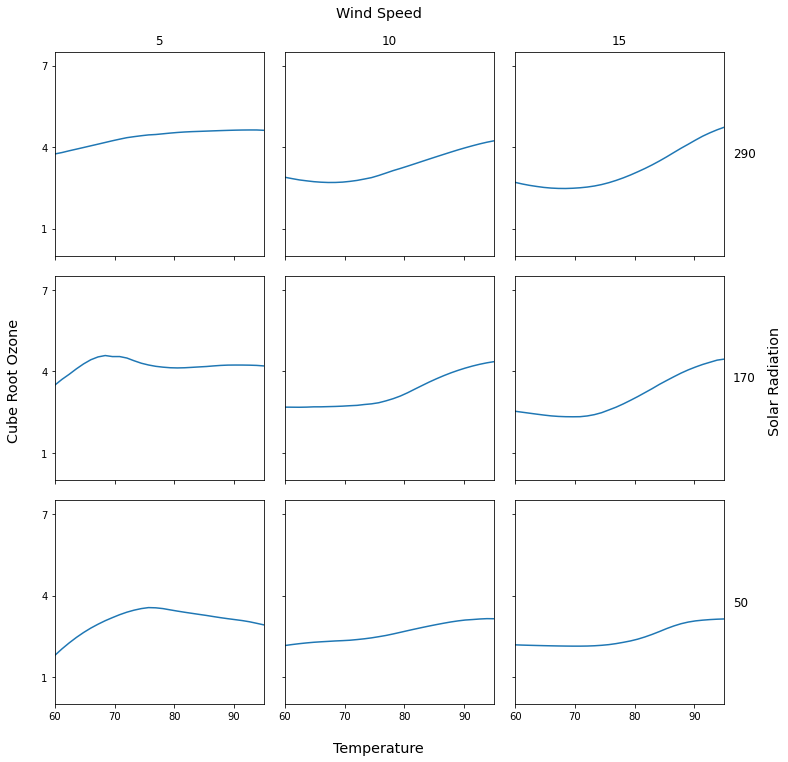

In [82]:
x=data[['radiation', 'temperature', 'wind']].to_numpy()

y = np.cbrt(data['ozone'].to_numpy())

size = 30

winds = [5.0, 10.0, 15.0]
radiations = [290.0, 170.0, 50.0]

fig, axs = plt.subplots(3,3,sharex='col', sharey='row', figsize=(12,12))
fig.text(0.07, 0.5, 'Cube Root Ozone', va='center', rotation='vertical', transform=fig.transFigure, fontsize='x-large')
fig.text(0.95, 0.5, 'Solar Radiation', va='center', rotation='vertical', transform=fig.transFigure, fontsize='x-large')
fig.text(0.5, 0.07, 'Temperature', ha='center', transform=fig.transFigure, fontsize='x-large')
fig.text(0.5, 0.92, 'Wind Speed', ha='center', transform=fig.transFigure, fontsize='x-large')


plt.subplots_adjust(wspace=0.1, hspace=0.1)


for i in range(3):
    axs[i,2].text(1.04, 0.5, str(int(radiations[i])), va='center',transform=axs[i,2].transAxes, fontsize='large')
    axs[i,0].set_yticks([1,4,7])
    for j in range(3):
        if i==0:
            axs[0,j].text(0.5, 1.04, str(int(winds[j])), ha='center',transform=axs[0,j].transAxes, 
                          fontsize='large')
            
            
        
        radiation = radiations[i]
        wind = winds[j]
        temperature = np.column_stack((np.full(size,radiation), np.linspace(60,95,size,dtype="float64"), 
                                                                            np.full(size,wind)))

        estimates, L = loess(x, y, temperature, f=0.8, fit=2, dist=2, normal=True)

        axs[i,j].plot(temperature[:,1], estimates)
        axs[i,j].set_ylim((0.0,7.5))
        axs[i,j].set_xlim((60.0,95.0))



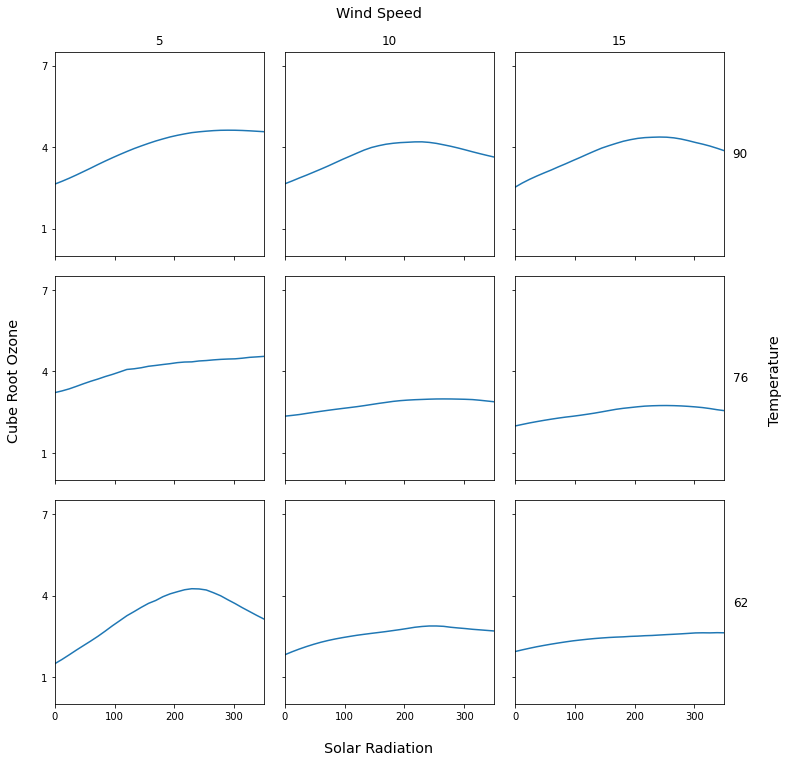

In [81]:
x=data[['radiation', 'temperature', 'wind']].to_numpy()

y = np.cbrt(data['ozone'].to_numpy())

size = 30

winds = [5.0, 10.0, 15.0]
temperatures = [90.0, 76.0, 62.0]

fig, axs = plt.subplots(3,3,sharex='col', sharey='row', figsize=(12,12))
fig.text(0.07, 0.5, 'Cube Root Ozone', va='center', rotation='vertical', transform=fig.transFigure, fontsize='x-large')
fig.text(0.95, 0.5, 'Temperature', va='center', rotation='vertical', transform=fig.transFigure, fontsize='x-large')
fig.text(0.5, 0.07, 'Solar Radiation', ha='center', transform=fig.transFigure, fontsize='x-large')
fig.text(0.5, 0.92, 'Wind Speed', ha='center', transform=fig.transFigure, fontsize='x-large')


plt.subplots_adjust(wspace=0.1, hspace=0.1)


for i in range(3):
    axs[i,2].text(1.04, 0.5, str(int(temperatures[i])), va='center',transform=axs[i,2].transAxes, fontsize='large')
    axs[i,0].set_yticks([1,4,7])
    for j in range(3):
        if i==0:
            axs[0,j].text(0.5, 1.04, str(int(winds[j])), ha='center',transform=axs[0,j].transAxes, 
                          fontsize='large')
            axs[0,j].set_xticks([0,100,200,300])
            
        
        temp = temperatures[i]
        wind = winds[j]
        radiation = np.column_stack((np.linspace(0,350,size,dtype="float64"), np.full(size,temp),  
                                                                            np.full(size,wind)))

        estimates, L = loess(x, y, radiation, f=0.8, fit=2, dist=2, normal=True)

        axs[i,j].plot(radiation[:,0], estimates)
        axs[i,j].set_ylim((0.0,7.5))
        axs[i,j].set_xlim((0.0,350.0))



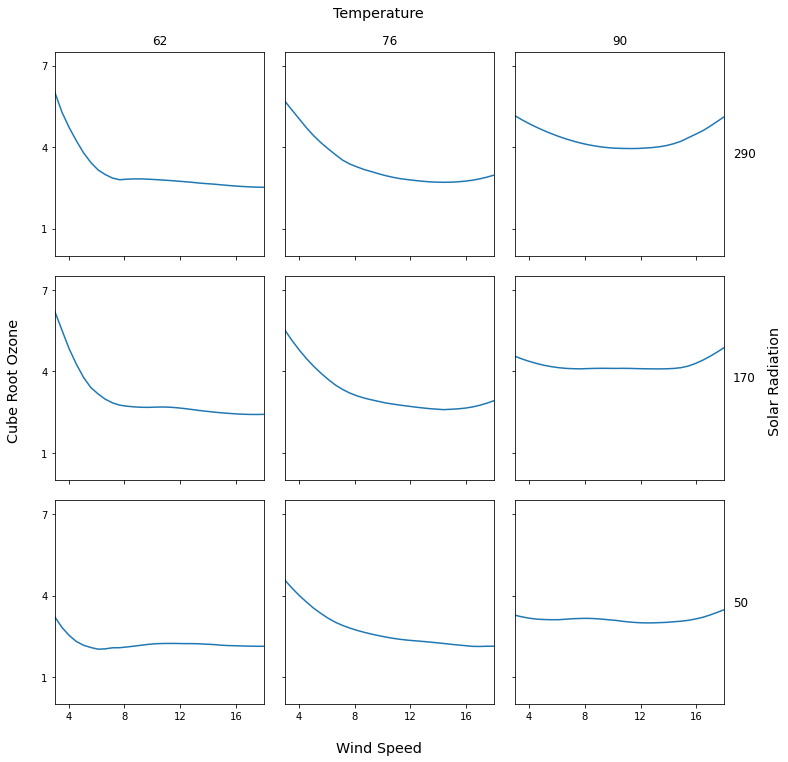

In [79]:
x=data[['radiation', 'temperature', 'wind']].to_numpy()

y = np.cbrt(data['ozone'].to_numpy())

size = 30

temperatures = [62.0, 76.0, 90.0]
radiations = [290.0, 170.0, 50.0]

fig, axs = plt.subplots(3,3,sharex='col', sharey='row', figsize=(12,12))
fig.text(0.07, 0.5, 'Cube Root Ozone', va='center', rotation='vertical', transform=fig.transFigure, fontsize='x-large')
fig.text(0.95, 0.5, 'Solar Radiation', va='center', rotation='vertical', transform=fig.transFigure, fontsize='x-large')
fig.text(0.5, 0.07, 'Wind Speed', ha='center', transform=fig.transFigure, fontsize='x-large')
fig.text(0.5, 0.92, 'Temperature', ha='center', transform=fig.transFigure, fontsize='x-large')


plt.subplots_adjust(wspace=0.1, hspace=0.1)


for i in range(3):
    axs[i,2].text(1.04, 0.5, str(int(radiations[i])), va='center',transform=axs[i,2].transAxes, fontsize='large')
    axs[i,0].set_yticks([1,4,7])
    for j in range(3):
        if i==0:
            axs[0,j].text(0.5, 1.04, str(int(temperatures[j])), ha='center',transform=axs[0,j].transAxes, 
                          fontsize='large')
            axs[0,j].set_xticks([4,8,12,16])
            
        
        radiation = radiations[i]
        temp = temperatures[j]
        wind = np.column_stack((np.full(size,radiation), np.full(size,temp), 
                                np.linspace(3,18,size,dtype="float64")))

        estimates, L = loess(x, y, wind, f=0.8, fit=2, dist=2, normal=True)

        axs[i,j].plot(wind[:,2], estimates)
        axs[i,j].set_ylim((0.0,7.5))
        axs[i,j].set_xlim((3.0,18.0))
        



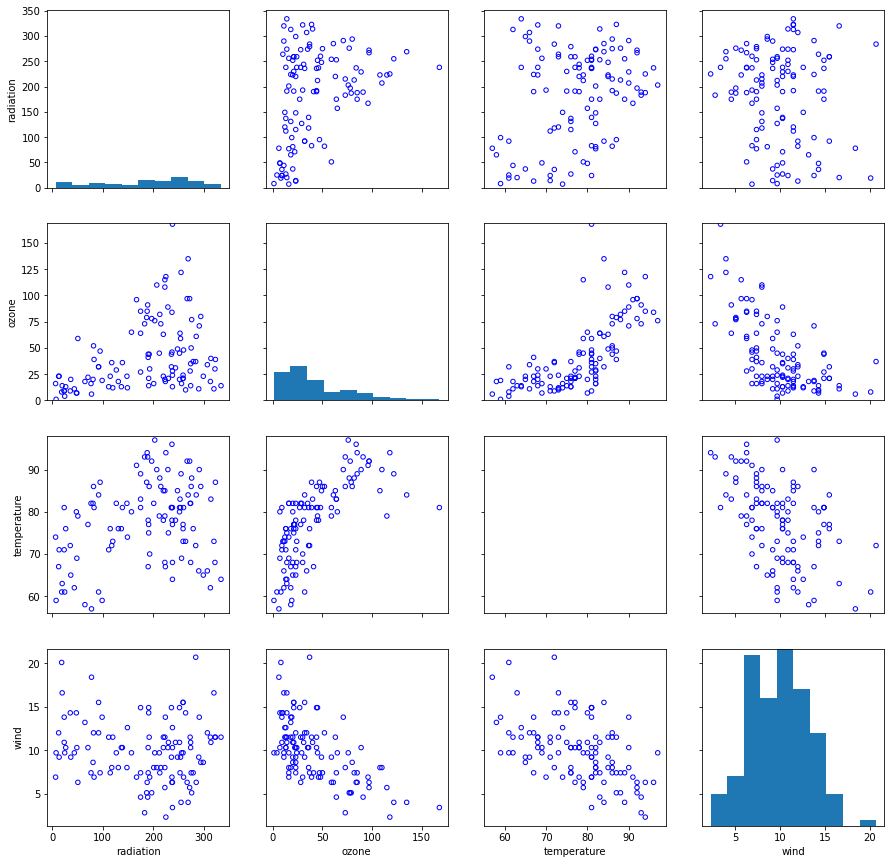

In [120]:

cols = ['radiation','ozone','temperature','wind']
fig, axs = plt.subplots(4,4,sharex='col', sharey='row', figsize=(15,15))
        
axs[0,0].set_ylabel(cols[0])
axs[3,3].set_xlabel(cols[3])
for i in range(0,4):
    for j in range(0,4):
        if i!=j:
            
            if(j==0):
                data.plot.scatter(x=cols[j], y=cols[i], ax=axs[i,j], subplots=True, sharey=True, 
                                  ylabel=cols[i], ylim=(data[cols[i]].min()-1, data[cols[i]].max()+1),
                                  c='none', edgecolor='b')
            else:
                data.plot.scatter(x=cols[j], y=cols[i], ax=axs[i,j], 
                          subplots=True, sharey=True, c='none', edgecolor='b')
        
        else:
            axs[i,i].hist(data[cols[i]],10)
            

axs[3,2].set_xticks([60,70,80,90])
axs[3,3].set_xticks([5,10,15,20])